# Selección de Características

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.datasets import make_blobs
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, mutual_info_classif, f_classif, f_regression, mutual_info_regression
%matplotlib inline

## Caso resuelto: predictores categóricos, respuesta categórica

dataset: `breast-cancer`

### Lectura y codificación del dataset

Comenzamos leyendo nuestro dataset y aplicando las transformaciones necesarias en el mismo para poder trabajar con él y que nuestros modelos sean capaces de procesarlo.

In [2]:
# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    data = pd.read_csv(filename, header=None)
    # retrieve numpy array
    dataset = data.values
    # split into input (X) and output (y) variables
    X = dataset[:, :-1]
    y = dataset[:,-1]
    # format all fields as string
    X = X.astype(str)
    return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc


# load the dataset
X, y = load_dataset('./datos/'+'breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

Guardamos los datos en formato DataFrame

In [3]:
column_names = ['age', 'menopause', 'tumor-size', 'inv-nodes', 
                'node-caps','deg-malig', 'breast', 'breast-quad','Class']
df = pd.DataFrame(X_train_enc, columns=column_names)

In [4]:
df

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,Class
0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0
1,1.0,2.0,9.0,0.0,0.0,1.0,0.0,3.0,0.0
2,3.0,2.0,10.0,0.0,1.0,1.0,1.0,2.0,1.0
3,1.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,2.0,3.0,0.0,0.0,1.0,1.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...
186,2.0,2.0,4.0,0.0,0.0,0.0,1.0,3.0,0.0
187,3.0,2.0,4.0,0.0,0.0,2.0,1.0,1.0,1.0
188,4.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
189,4.0,0.0,7.0,0.0,0.0,1.0,1.0,1.0,0.0


### Mutual information

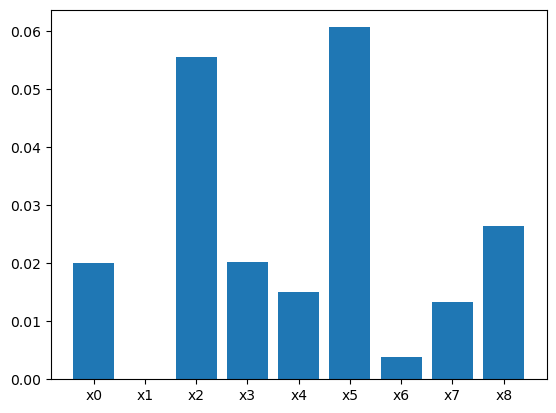

In [5]:
# feature selection mutual information
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k=4)
    # Fits the model to get which are the best samples
    fs.fit(X_train, y_train)

    # Returns selected features for the given samples
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs, fs

# feature selection (using the encoded datset to train our model)
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# plot the scores
plt.bar([f'x{i}' for i in range(len(fs.scores_))],
        fs.scores_)
plt.show()

El parámetro *discrete_features* de la función `mutual_info_classif` sirve para indicar si las variables que pertenecen al dataset de entrada son discretas o continuas. Al darle un valor de 'auto', un algoritmo detecta cuales de ellas son discretas y cuales continuas, en función del número de valores distintos que tenga la variable. Por ello, si obtenemos los datos de entrenamiento en el mismo chunk que se llama a esta función, la misma parecerá tener un carácter aleatorio, pues las variables son interpretadas de una forma u otra para distintos datos y, en consecuencia, se aplica un método para calcular la entropía u otro. En función de la ordenación de los datos, obtendremos un resultado u otro. 

Para resolver este problema, definimos el parámetro a True, pues estamos trabajando con variables discretas, de forma que:

In [6]:
def mi_mutual_info_classif(*args):
    return mutual_info_classif(args[0], args[1], discrete_features=True)

Así, si aplicamos de nuevo nuestra selección de características, con esta función de información mutua, obtenemos

In [7]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mi_mutual_info_classif, k=4)
    fs.fit(X_train, y_train)

    # Returns selected features for the given samples
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs, fs

_, _, mi = select_features(X_train_enc, y_train_enc, X_test_enc)
mi.get_feature_names_out()

array(['x2', 'x3', 'x4', 'x5'], dtype=object)

Si realizamos un número determinado de ejecuciones, veremos como obtenemos siempre el mismo resultado:

In [8]:
_, _, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
fsn = fs
result = True
for i in range(10):
    _, _, fsn = select_features(X_train_enc, y_train_enc, X_test_enc)
    if ((fs.get_feature_names_out() != fsn.get_feature_names_out()).all()):
        result = False
        break

    fs = fsn

print(result)

True


### $\chi^{2}$     (chi cuadrado)

Supongamos que se clasifican $n$ observaciones de una muestra aleatoria de una población en $k$ clases mutuamente exclusivas con números respectivos observados $x_i$, para $i=1,....,k$. Se establece, además, una hipótesis nula de independencia entre las variables aleatorias en base a las cuales se clasifican dichas observaciones. Si definimos la probabilidad $p_i$ de que una observación se encuentre dentro de la i-ésima clase, se tienen los números esperados $m_i = np_i$ para todo i, donde

-  $\sum_i p_i = 1$
-  $\sum_i m_i = \sum_i np_i = n$
-  $\sum_i p_i = 1$

Pearson propuso que, bajo la hipótesis de que la hipótesis nula es cierta, en la medida que n → ∞ la distribución límite de la cantidad indicada abajo es la distribución χ2.
- χ2 $= \sum_i {\frac{(x_i - m_i)^2}{m_i}} = \sum_i{\frac{x_{i}^2}{m_{i}}-n}$.

Supongamos que tenemos el siguiente caso, en el que se nos aporta la siguente tabla de contingencia para las variables 'género' y 'causa baja en el trabajo'
| Género | Si      | No      | Total |
| ------ | ------- | ------- | ----- |
| Hombre | 38      | 178     | 216   |
| Mujer  | 44      | 140     | 184   |
| Total  | 82      | 318     | 400   |

Sea considerada cierta la hipótesis nula y, por tanto, que las variables genero y baja en el servicio son independientes. Si calculamos la tabla de valores esperados de las cuatro clases sabiendo que, por ejemplo, 
- $P(Si \cap Hombre) = \frac{82}{400}\frac{216}{400} \Rightarrow E[Si \cap Hombre] = N\cdot P(Si \cap Hombre) = 44$

Obtenemos lo siguiente
| Género | Si      | No      |
| ------ | ------- | ------- |
| Hombre | 44      | 172     |
| Mujer  | 38      | 146     |

Si aplicamos lo ya mencionado para estos datos, obtenemos para las cuatro clases existentes que nuestro estadístico tomará el valor χ2 $=2.2214$. Luego, como la variable aleatoria $\sum_i {\frac{(x_i - m_i)^2}{m_i}}$ sigue una distribución Chi cuadrado, con ... grados de libertad, podemos calcular el intervalo de confianza clásico para un nivel de confianza $\alpha$. Así, para un nivel de confianza concreto obtendremos un valor de χ2' que deja por encima suyo una probabilidad de $1-\alpha$. Así, basta ver si χ2 $<$ χ2' para ver si nos encontramos o no dentro del intervalo de aceptación de la hipótesis nula, o si, por el contrario, debemos rechazarla.

Para nuestro caso, nos encontramos con algo muy similar, solo que cambia el número de características, pero no su naturaleza. No obstante, lo que haremos realmente es comparar cada una de las variables de entrada con la de salida, para ver cuales son las que más afectan el resultado (esto lo haremos comprobando el valor de $\chi^{2}$ para cada una de las variables de entrada). Así, obtenemos lo siguiente

Se han escogido las características ['x3' 'x4' 'x5' 'x8'] y el dataset de salida se ha reducido a las dimensiones (191, 4)


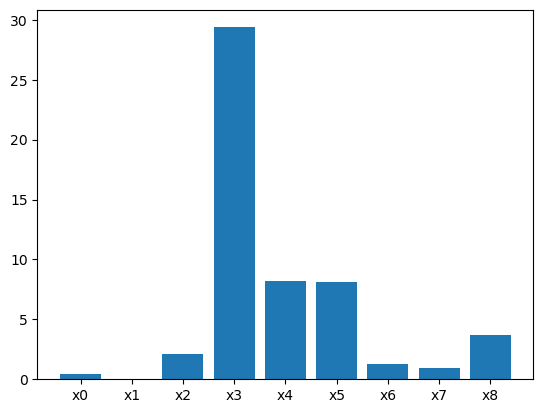

In [9]:
# feature selection
from sklearn.feature_selection import chi2

def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k=4)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, chi = select_features(X_train_enc, y_train_enc, X_test_enc)
print(f'Se han escogido las características {chi.get_feature_names_out()} y el dataset de salida se ha reducido a las dimensiones ' + str(X_train_fs.shape))

plt.bar([f'x{i}' for i in range(len(chi.scores_))], chi.scores_)
plt.show()

¿Cómo saber qué características se han seleccionado?

In [10]:
print(chi.get_feature_names_out())
print(chi.get_support())
print(np.nonzero(chi.get_support()))
print([column_names[idx] for (idx, item) in enumerate(chi.get_support()) if item])

['x3' 'x4' 'x5' 'x8']
[False False False  True  True  True False False  True]
(array([3, 4, 5, 8], dtype=int64),)
['inv-nodes', 'node-caps', 'deg-malig', 'Class']


Si comparamos los resultados obtenidos para cada estadístico

In [11]:
def select_features(X_train, y_train, X_test, f):
    fs = SelectKBest(score_func=f, k=4)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [12]:
def score(funcs, X_train, y_train, X_test):
    """
    Función que calcula los scores de cada característica para cada función
    de selección de características.

    :param funcs: funciones de selección de características
    :return: diccionario con los scores de cada característica para cada función
    """

    d = {f'f{i+1}': 0 for i in range(len(funcs))}

    for i, f in enumerate(funcs):
        _, _, fs = select_features(X_train, y_train, X_test, f)
        d[f'f{i+1}'] = fs.scores_

    return d

<AxesSubplot: >

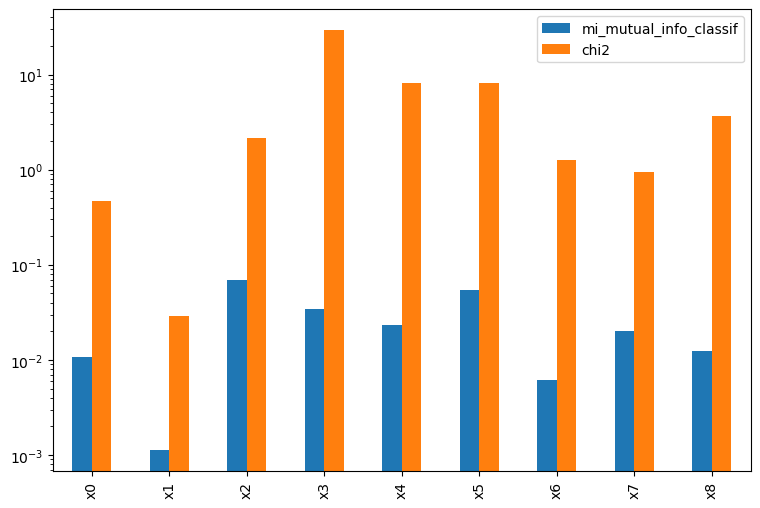

In [13]:
d = score([mi_mutual_info_classif, chi2], X_train_enc, y_train_enc, X_test_enc)
df = pd.DataFrame(d, index=[f'x{i}' for i in range(len(d['f1']))])
df.columns = ['mi_mutual_info_classif', 'chi2']
df.plot(kind='bar', 
        figsize=(9,6), 
        legend=True,
        logy=True)

Por lo que vemos que existen discrepancias entre ambos estadísticos.

### Comparación de rendimiento

Evaluación de las dos selecciones de características usando como referencia un modelo de regresión logística

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def select_features(X_train, y_train, X_test, func, k=4):
    fs = SelectKBest(score_func=func, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

l = []
model = LogisticRegression(solver='lbfgs')

for k in range(1, 10):
    # feature selection
    X_train_fs, X_test_fs, fs = select_features(X_train_enc, 
                                                y_train_enc, 
                                                X_test_enc, chi2, k)
    model.fit(X_train_fs, y_train_enc)
    yhat = model.predict(X_test_fs)
    accuracy = accuracy_score(y_test_enc, yhat)

    # feature selection
    X_train_fs, X_test_fs, fs = select_features(X_train_enc, 
                                                y_train_enc, 
                                                X_test_enc,
                                                mi_mutual_info_classif,
                                                k)
    model.fit(X_train_fs, y_train_enc)
    yhat = model.predict(X_test_fs)
    accuracy_mi = accuracy_score(y_test_enc, yhat)

    l += [(k, accuracy, accuracy_mi)]

,chi2,mi
1,0.673684,0.652632
2,0.663158,0.673684
3,0.736842,0.768421
4,0.747368,0.736842
5,0.736842,0.747368
6,0.747368,0.747368
7,0.747368,0.736842
8,0.757895,0.757895
9,0.757895,0.757895


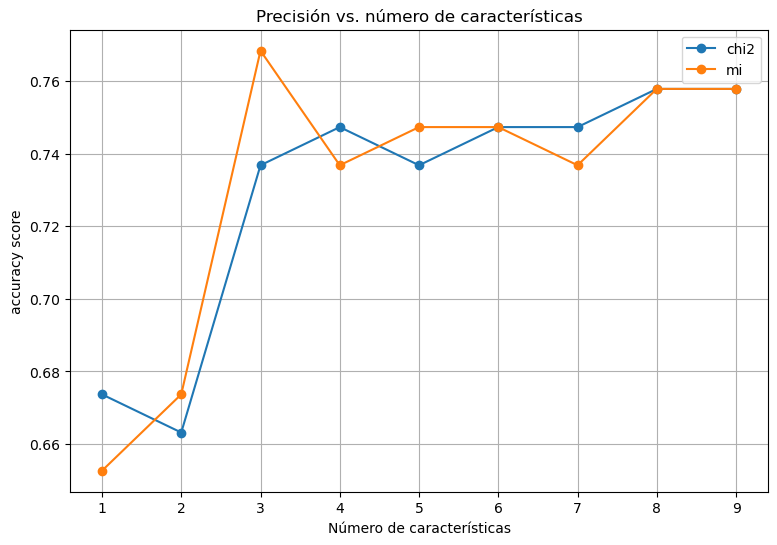

In [15]:
df = pd.DataFrame({'chi2': [k for _, k, _ in l],
                   'mi': [k for _, _, k in l]}, index=range(1,10))
from IPython.display import display
display(df)

df.plot(style='o-', grid=True, figsize=(9,6),
        xticks=[i for i in range(1,10)],
        title='Precisión vs. número de características', 
        xlabel='Número de características',
        ylabel='accuracy score')
plt.show()

### Conclusiones

Después de analizar los datos, es difícil determinar cuál de los dos métodos estadísticos es mejor, ya que ambos proporcionan resultados diferentes y la elección depende del número de características que se estén utilizando. Sin embargo, si nos fijamos en los resultados específicos en la gráfica, el estadístico mi (mutual information) parece ser el mejor cuando se utilizan 3 características, ya que da el valor más alto para ese número. Por lo tanto, si se desea utilizar un método estadístico para analizar la relación entre variables y se cuenta con 3 características, el estadístico mi podría ser la mejor opción.

## Caso propuesto 1: predictores númerico, respuesta categórica

dataset: `pima-indians-diabetes`

### Lectura del dataset

Lo primero que haremos será definir una clase que nos permita cargar los datasets de una forma cómoda y rápida, a la cual llamaremos `DataSetLoader`

In [16]:
class DataSetLoader:
    """
    Clase que permite cargar los datasets de la carpeta datos
    """
    def __init__(self, root):
        """
        Constructor de la clase DataSetLoader

        :param str root: ruta de la carpeta que contiene los datasets
        """
        
        self.root = root
        self.datasets = self.get_names()

    def get_names(self):
        """
        Función que obtiene los nombres de los datasets de la carpeta
        indicada por el campo de clase root.
        
        :return: lista de nombres de los datasets
        """

        return [file for file in os.listdir(self.root)if file.endswith('.csv')]

    def load_dataset(self, dataset, h=None):
        """
        Función que carga un dataset en un DataFrame de pandas

        :param str dataset: nombre del dataset a cargar
        :param int h: número de fila que contiene los nombres de las columnas
        :return: DataFrame con los datos del dataset
        """

        dataset = pd.read_csv('./datos/' + self.datasets[dataset], header=h)
        return dataset

Hecho esto, cargamos nuestro conjunto de datos

In [17]:
dataSetLoader = DataSetLoader('./datos')
dataSetLoader.datasets
dataset = dataSetLoader.load_dataset(1, h=None)

# Nombre de las características
cols = ['npregnants', 'glucose', 'pressure', 'thickness', 'insulin', 'bmi', 'pedigree', 'age', 'target']
dataset.columns = cols

dataset

,npregnants,glucose,pressure,thickness,insulin,bmi,pedigree,age,target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### División el dataset en train y test

En este apartado, se ha dividido el dataset en train y test, con un 80% de los datos para entrenamiento y un 20% para test.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(dataset.values[:, :-1], dataset.values[:, -1], test_size=0.3, random_state=123)

### Codificación del dataset

Lo primero que haremos será definir una clase que nos permita codificar los datasets de una forma cómoda y rápida, a la cual llamaremos `Encoder`

In [19]:
class Encoder:
    """
    Clase que permite codificar las variables categóricas de un conjunto de datos
    de entrenamiento y de testeo.
    """
    
    def __init__(self):
        pass

    def encode(self, X_train, X_test, y = None, oe_columns=None, str_columns=None):
        """
        Función que codifica las variables categóricas de un conjunto de datos
        de entrenamiento y de testeo.
        
        :param X_train: conjunto de datos de entrenamiento
        :param X_test: conjunto de datos de testeo
        :param y: vector de clases
        :param oe_columns: lista de columnas a codificar con OrdinalEncoder
        :param str_columns: lista de columnas a codificar con StandardScaler
        :return: conjunto de datos de entrenamiento, conjunto de datos de testeo y
                vector de clases codificados
        """
        oe = OrdinalEncoder()
        le = LabelEncoder()
        str = StandardScaler()

        X_train = X_train.copy()
        X_test = X_test.copy()

        if ((type(X_train) == np.ndarray) | (type(X_test) == np.ndarray)):
            X_test = pd.DataFrame(X_test)
            X_train = pd.DataFrame(X_train)
        
        if oe_columns: 
            X_train[oe_columns] = oe.fit_transform(X_train[oe_columns])
            X_test[oe_columns] = oe.transform(X_test[oe_columns])
        if str_columns:
            str.fit(X_train[str_columns])
            X_train[str_columns] = str.fit_transform(X_train[str_columns])
            X_test[str_columns] = str.transform(X_test[str_columns])
        if y:
            result = y.copy()
            result = result.to_frame()
            result = le.transform(result)
            return X_train, X_test, result

        return X_train, X_test

In [20]:
encoder = Encoder()
X_train_std, X_test_std = encoder.encode(X_train, X_test, str_columns = [i for i in range(len(dataset.columns) -1)])

In [21]:
X_train_std

,0,1,2,3,4,5,6,7
0,-0.847578,-0.798899,0.676254,0.274401,0.842498,0.384935,-0.695485,0.815489
1,-0.244332,0.147027,-0.596462,-1.321715,-0.704330,-0.065097,-0.943389,-0.789224
2,0.962161,1.849692,1.365642,0.657469,-0.704330,0.279045,-0.904087,2.251285
3,2.168653,-0.546652,-0.066164,1.232071,-0.704330,1.867392,-1.018969,0.731031
4,-1.149201,-0.357467,0.994433,0.593624,-0.704330,0.054029,1.184953,0.393196
...,...,...,...,...,...,...,...,...
532,0.660538,-0.861960,-1.020701,0.593624,-0.154347,-0.448947,-0.323630,-0.873682
533,-1.149201,0.115496,0.039896,-0.044822,-0.704330,-0.621018,-0.631998,0.224279
534,-0.847578,-0.357467,-0.490403,-0.810958,0.859685,-0.885742,1.463089,-1.042599
535,0.358915,-0.672775,-0.808582,0.465935,0.008930,0.252573,0.108689,-0.282472


### Feature selection

Definimos la función que nos permitirá, dado unos datos de entrada, escoger aquellas características que sean mejores según el estadístico que se le indique mediante el parámetro $f$.

In [22]:
def select_features(X_train, y_train, X_test, f, k=4):

        """
        Función que selecciona las k mejores características de un conjunto de datos
        de entrenamiento y de testeo.

        :param X_train: conjunto de datos de entrenamiento
        :param y_train: vector de clases de entrenamiento
        :param X_test: conjunto de datos de testeo
        :param f: función de evaluación de características
        :param k: número de características a seleccionar
        :return: conjunto de datos de entrenamiento, conjunto de datos de testeo y
                objeto SelectKBest con las características seleccionadas
        """
        fs = SelectKBest(score_func=f, k=k)
        fs.fit(X_train, y_train)
        # Returns selected features for the given samples
        X_train_fs = fs.transform(X_train)
        X_test_fs = fs.transform(X_test)
        return X_train_fs, X_test_fs, fs

### Estadístico F (o F-Score)

El estadístico f-score trata de medir como de separadas están dos clases para una característica concreta. Supongamos que tenemos un dataset con dos variables, $x_1, x_2$, con tan solo dos clases.

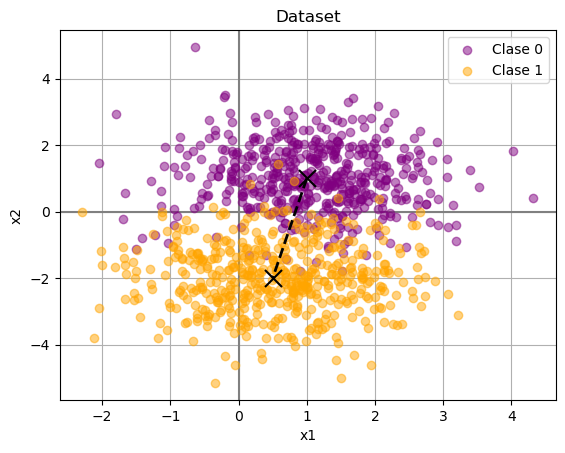

In [23]:
X_ex, y_ex = make_blobs(n_samples=1000, centers=[(1,1), (0.5,-2)], n_features=2, random_state=1)
df = pd.DataFrame(X_ex, columns=['x1', 'x2'])
df['target'] = y_ex

plt.scatter(df[df['target'] == 0]['x1'], df[df['target'] == 0]['x2'], color='purple', alpha=0.5, zorder=3)
plt.scatter(df[df['target'] == 1]['x1'], df[df['target'] == 1]['x2'], color='orange', alpha=0.5, zorder=3)
plt.legend(['Clase 0', 'Clase 1'])

plt.axvline(x=0, color='gray')
plt.axhline(y=0, color='gray')
plt.grid(zorder=0)

plt.scatter(1, 1, color='black', marker='x', s=150, zorder=3)
plt.scatter(0.5, -2, color='black', marker='x', s=150, zorder=3)
plt.plot([1, 0.5], [1, -2], color='black', linestyle='--', linewidth=2, zorder=3)

plt.xlabel('x1')
plt.ylabel('x2')

plt.title('Dataset')

plt.show()

Podemos ver cómo, si tuvieramos que escoger una única característica de los datos para inferir sobre la clase a la que pertenece una muestra, claramente escogeríamos $x_2$, pues esta nos aporta mucha más información sobre su clase que $x_1$. Esto se debe a que las densidades de ambas clases tienen para la característica $x_2$ una mayor distancia de medias y una menor dispersión que para la variable $x_1$. Es estadístico f-score trata de medir esto.

Así, nos interesa buscar cuales son esas características que nos permitan inferir mejor las clases de nuestro dataset, teniendo en cuenta la distancia y dispersión de las clases para cada una de ellas. Para ello, hacemos uso del modelo `SelectKBest` de scikit-learn, el cual nos permite seleccionar las _k_ mejores características de un dataset, según el estadístico que le indiquemos. En nuestro caso, usaremos el estadístico `f_classif`, que es el nombre que se le da al estadístico f-score en scikit-learn. Si mostramos los distintos f-scores obtenidos para cada una de las características, vemos que la característica 1 es la que tiene mayor f-score, por lo que es la que mejor nos permite inferir sobre la clase de las muestras por separado.

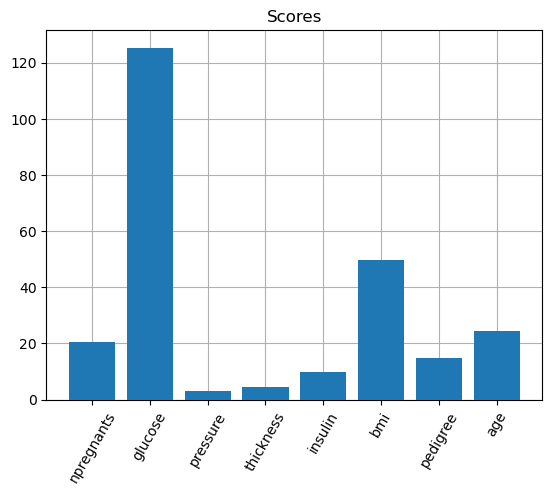

In [24]:
X_train_f, X_test_f, fs = select_features(X_train_std, y_train, X_test_std, f_classif)
plt.bar(cols[:-1], fs.scores_, zorder=3)
plt.xticks(rotation=60)
plt.title('Scores')
plt.grid(zorder=0)
plt.show()

Resulta que, si realizamos un density plot de la característica Gluscose con cualquier otra de las variables de nuestro dataset, podremos apreciar como las distribuciones de esta primera variable para las distintas clases están menos solapadas que para el resto. A continuación, mostramos unas cuantas comparaciones de la variable Glucose con el resto de variables.

<center>Glucose vs. Pressure

In [25]:
def plot_density(df, x1, x2):
    """
    Función que grafica las densidades de dos características de un conjunto de datos
    y las esperanzas de cada una de ellas.

    :param df: conjunto de datos
    :param x1: nombre de la primera característica
    :param x2: nombre de la segunda característica
    :return: gráfica de las densidades de las características y sus esperanzas
    """

    # Densidades de cada clase
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.kdeplot(df[df['target'] == 0][x1], ax=ax[0], label='Clase 0')
    sns.kdeplot(df[df['target'] == 1][x1], ax=ax[0], label='Clase 1')
    ax[0].legend(['Clase 0', 'Clase 1'])

    sns.kdeplot(df[df['target'] == 0][x2], ax=ax[1], label='Clase 0')
    sns.kdeplot(df[df['target'] == 1][x2], ax=ax[1], label='Clase 1')

    # Esperanza de cada densidad
    ax[0].axvline(x=df[df['target'] == 0][x1].mean(), color='blue', linestyle='--', linewidth=2, alpha=0.4)
    ax[0].axvline(x=df[df['target'] == 1][x1].mean(), color='orange', linestyle='--', linewidth=2)

    ax[1].axvline(x=df[df['target'] == 0][x2].mean(), color='blue', linestyle='--', linewidth=2, alpha=0.4)
    ax[1].axvline(x=df[df['target'] == 1][x2].mean(), color='orange', linestyle='--', linewidth=2)

    # Disctancia entre esperanzas
    ax[0].annotate('', xy=(df[df['target'] == 0][x1].mean(), 0.25), xytext=(df[df['target'] == 1][x1].mean(), 0.25),
                    arrowprops=dict(arrowstyle='<->', color='black', linewidth=2))
    ax[1].annotate('', xy=(df[df['target'] == 0][x2].mean(), 0.3), xytext=(df[df['target'] == 1][x2].mean(), 0.3),
                    arrowprops=dict(arrowstyle='<->', color='black', linewidth=2))

    # Algunas configuaraciones del gráfico
    ax[0].legend(['Clase 0', 'Clase 1', 'Esperanza Clase 0', 'Esperanza Clase 1'])
    ax[1].legend(['Clase 0', 'Clase 1', 'Esperanza Clase 0', 'Esperanza Clase 1'])
    ax[0].set_title(f'{x1} density')
    ax[1].set_title(f'{x2} density')
    plt.show()

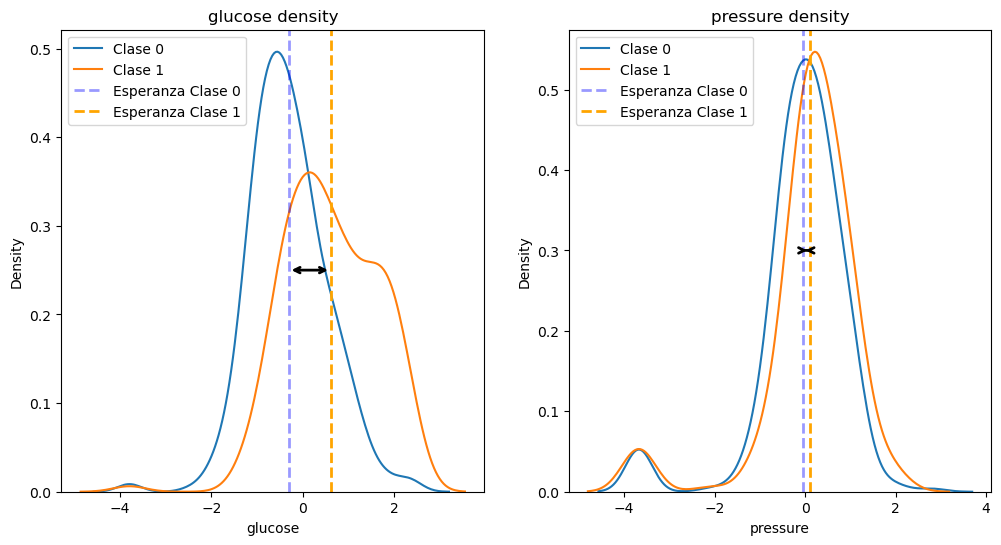

In [26]:
df = pd.DataFrame(X_train_std.copy())
df.columns = cols[:-1]
df['target'] = y_train

plot_density(df, 'glucose', 'pressure')


<center>Glucose vs. Age

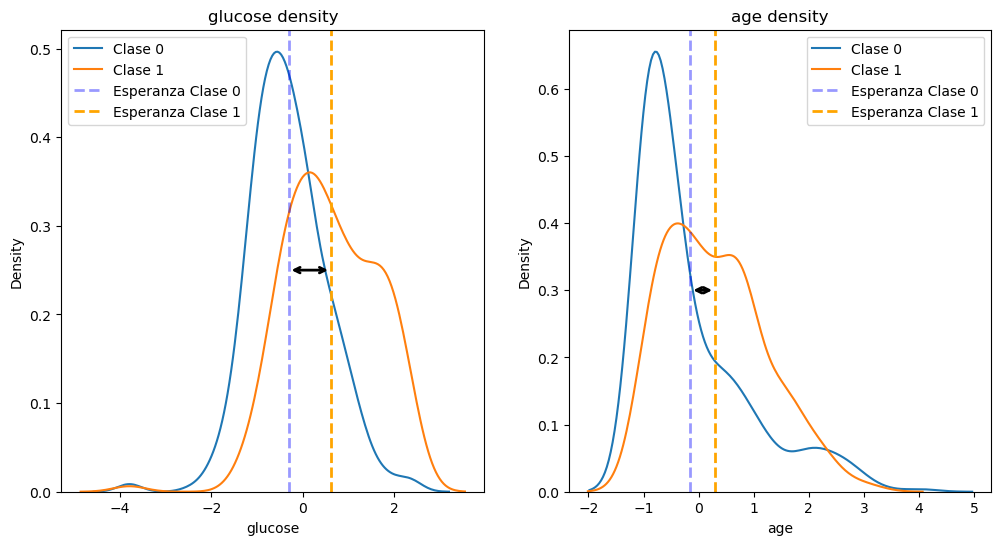

In [27]:
plot_density(df, 'glucose', 'age')

<center>Glucose vs. bmi

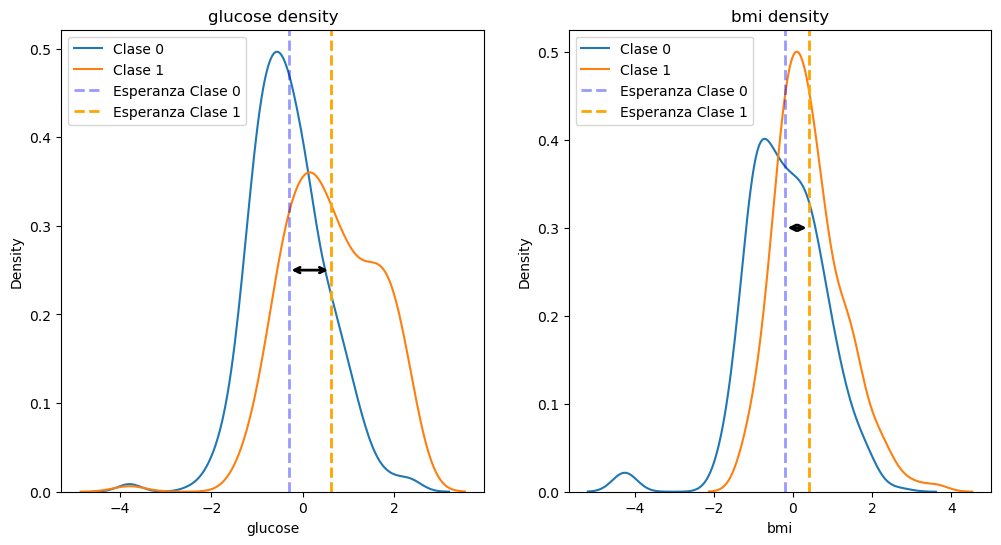

In [28]:
plot_density(df, 'glucose', 'bmi')

Ahora, si escogemos únicamente las cuatro mejores características, obtenemos el siguiente resultado:

In [29]:
X_train_4, X_test_4, fs4 = select_features(X_train_std, y_train, X_test_std, f_classif, k=4)
vars = [car for i, car in enumerate(cols[:-1]) if fs.get_support()[i]]

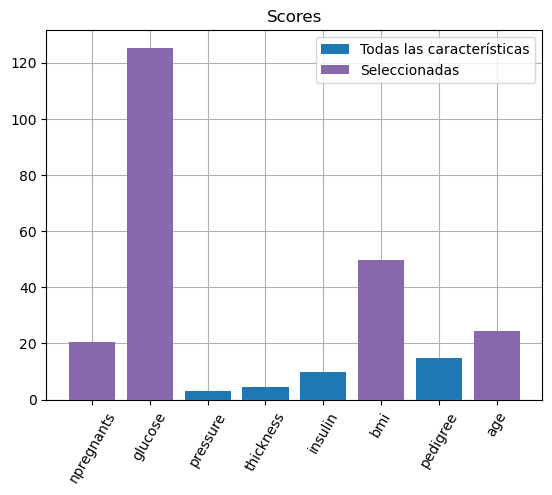

In [30]:
plt.bar(cols[:-1], fs.scores_, zorder=3)
plt.bar(vars, fs.scores_[fs.get_support()], color='#8768AC', zorder=3)
plt.legend(['Todas las características', 'Seleccionadas'])
plt.xticks(rotation=60)
plt.title('Scores')
plt.grid(zorder=0)
plt.show()

Si mostramos los resultados para cada clase, según las características escogidas:

<center>All vs. All

In [31]:
X_train_fs = pd.DataFrame(X_train_4, columns=vars)

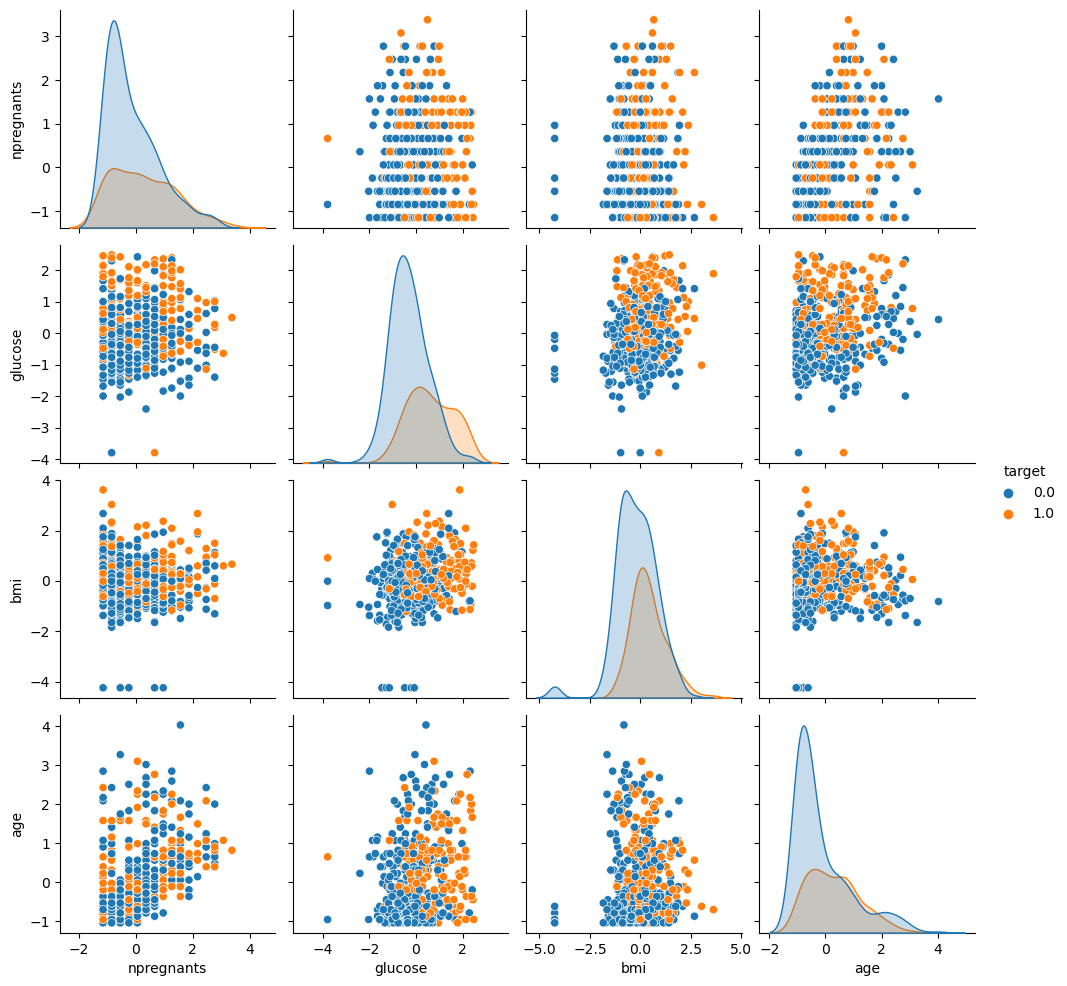

In [32]:
# Density plot for each class, comparing all features
X_train_fs = pd.DataFrame(X_train_4, columns=vars)
X_train_fs['target'] = y_train

sns.pairplot(X_train_fs, hue='target')
plt.show()

En consecuencia, Glucose es la mejor de las características predictoras a la hora de tomar decisiones sobre la clasificación de una muestra.

### Mutual information (caso clasificación)

Para entender el concepto de información mutua, debemos entender primero lo que es la entropía y la cantidad de información en sí misma de una variable aleatoria. Así, sea $X:\Omega \rightarrow \mathbb{R}$ dicha variable, definimos la nueva variable $I(X)$ como la cantidad de información que nos aporta dicha variable. De esta manera, tenemos una forma de conocer la cantidad de información asociada a un suceso. En teoría de la información, en relación al sistema numérico binario, se define dicha información, para un suceso $x\in \Omega$ dado, como $I(x) = -log_2(x)$.

Supongamos que tenemos una urna con 10 bolas, 9 negras y una blanca. La variable aleatoria que modelaría el experimento de sacar una bola de dicha urna, con bolas indistinguibles para un mismo color, tomaría dos posibles valores únicamente, sacar una bola blanca o una negra. Ahora bien, supongamos que realizamos el experimento. Si la bola que sacamos es blanca, y no existe reemplazamiento, entonces tenemos total certeza de que la próxima bola a extraer de la urna es negra, mientras que en el caso contrario seguiría existiendo una gran incertidumbre en el resulado. Sacar una bola de color blanco nos aporta mucha más información que sacar una negra. Esta información es la que tratamos de modelar.

Una vez claro el concepto de información, definimos la **entropía de una variable aleatoria** $X$, $H(X)$, como la esperanza de la variable $I(X)$, $E[I(X)]$. La entropía es, por tanto, el valor esperado de la cantidad de información que nos aporta conocer un valor de la variable aleatoria $X$. 

Ahora bien, dadas dos variables aleatorias $X, Y$, definimos la información mutua de ambas como $I(X,Y) = H(X) - H(X|Y)$. Nótese que a menor $H(X|Y)$, más probable será un evento concreto de $X|Y$ frente al resto, por lo que a menor sea la diferencia entre esta y $H(X)$, más información nos aporta conocer el resultado de la variable aleatoria $Y$ frente a al resultado de $X$ y, por tanto, mayor es la información mutua de ambas variables.

Hecha esta breve introducción, prosigamos con nuestro ejemplo. Lo primero que haremos será modificar el estadístico de mutual information que nos ofrece la librería *scikit-learn*, indicándo que queremos que nos devuelva la información mutua de dos variables predictoras **continuas**.

In [33]:
def mi_cont_mutual_info_classif(*args):
    """
    Wrapper para la función mutual_info_classif de sklearn que permite
    utilizarla con variables continuas.

    :param args: argumentos de la función mutual_info_classif
    :return: resultado de la función mutual_info_classif
    """
    
    return mutual_info_classif(*args, discrete_features=False)

In [34]:
X_train_fs, X_test_fs, fs = select_features(X_train_std, y_train, X_test_std, mi_cont_mutual_info_classif)
fs.get_feature_names_out()

array(['x1', 'x4', 'x5', 'x7'], dtype=object)

Donde se han obtenido las siguientes variables como mejores respecto a este estadístico:

In [35]:
np.array(cols[:-1])[fs.get_support()]

array(['glucose', 'insulin', 'bmi', 'age'], dtype='<U10')

Y si comparamos sus scores frente al resto, de forma visual, obtenemos el siguiente gráfico

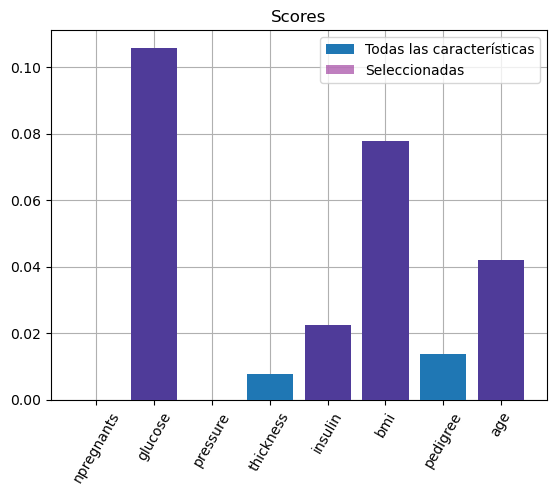

In [36]:
vars = [car for i, car in enumerate(cols[:-1]) if fs.get_support()[i]]
plt.bar(cols[:-1], fs.scores_, zorder=3)
plt.bar(vars, fs.scores_[fs.get_support()], color='purple', alpha=0.5, zorder=3)
plt.legend(['Todas las características', 'Seleccionadas'])
plt.xticks(rotation=60)
plt.title('Scores')
plt.grid(zorder=0)
plt.show()

### Comparación de estadísticos

Una vez obtenidas las mejores características para ambos estadísticos, procedemos a comparar los resultados obtenidos. Para ello, definimos una función que nos permita comparar los scores obtenidos por ambos estadísticos.

<AxesSubplot: >

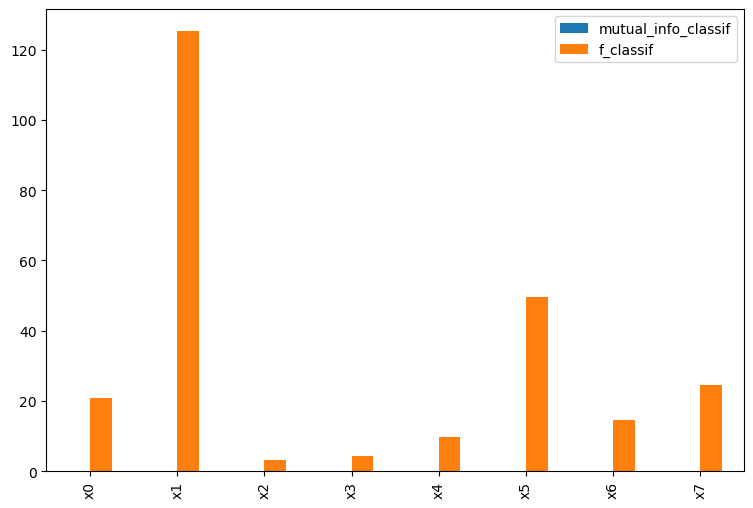

In [37]:
d = score([mutual_info_classif, f_classif], X_train_std, y_train, X_test_std)
df = pd.DataFrame(d, index=[f'x{i}' for i in range(len(d['f1']))])
df.columns = ['mutual_info_classif', 'f_classif']
df.plot(kind='bar', 
        figsize=(9,6), 
        legend=True)

Si aplicamos una escala logaritmica para el eje vertical para apreciar los resultados de ambos, obtenemos el siguiente gráfico:

<AxesSubplot: >

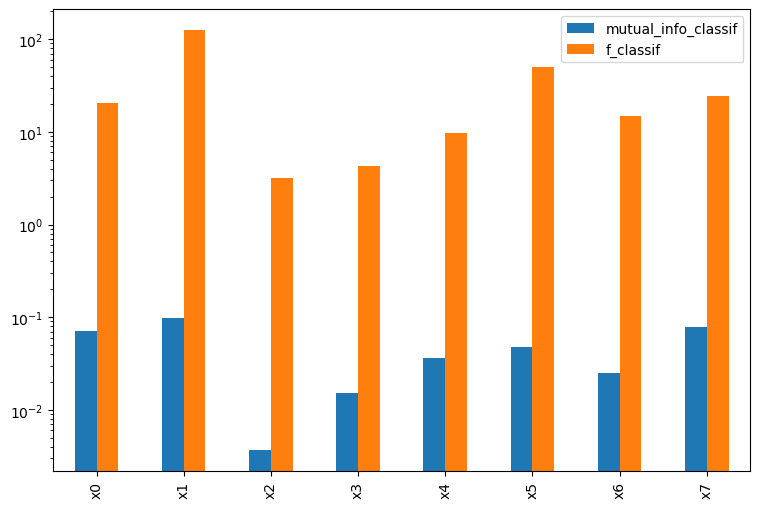

In [38]:
df.plot(kind='bar', 
        figsize=(9,6), 
        logy=True,
        legend=True,
        )

Por norma general, el estadístico mutual information tiende a escoger las mismas características que el estadístico f-score, para este dataset. No obstante, existe un cierto caracter pseudo-aleatorio en el estadístico mutual information que nos proporciona la librería *scikit-learn*, al tratarse de una función no determinista, cuando las características a estudiar son continuas, por lo que no es de extrañar que en ocasiones no se obtengan los mismos resultados.

### Modelo con todas las características

Usar el modelo `LogisticRegression(solver='liblinear')` y la métrica `accuracy_score`

A continuación, entrenamos un modelo con todas las características del dataset, para ver como de bien se comporta este modelo frente a los entrenados con las mejores características que escoge cada estadístico.

In [39]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_std, y_train)

yhat = model.predict(X_test_std)
accuracy = accuracy_score(y_test, yhat)
print(f'La precisión para el modelo con todas las características ha sido de: {accuracy:.2f}')

La precisión para el modelo con todas las características ha sido de: 0.80


Podemos, además, obtener los pesos del modelo para ver a qué característica se le atorga mayor importancia. A mayor valor absoluto del peso de una característica, mayor importancia tendrá en el proceso de clasificación. Para ello, accedemos al atributo *coef_* del modelo, y obtenemos el siguiente resultado

In [40]:
model.coef_

array([[ 0.38207795,  1.05724562, -0.20007416,  0.03787492, -0.19105064,
         0.69940814,  0.28832959,  0.12244733]])

Como era de esperar, la clase x1 tendrá un mayor peso asociado en valor absoluto, pues es la que nos aporta un mayor nivel de discriminación entre clases, como ya explicamos donde calculamos el propio F-Score.

### Modelo con las 4 mejores características descubiertas con F

Para la selección de estas caracteristicas usaremos la función `select_features()`, usando como función para la selección de características `f_classif()` con un _k_ igual a 4.

In [41]:
X_train_f, X_test_f, fs = select_features(X_train_std, y_train, X_test_std, f_classif, k=4)

In [42]:
modelf = LogisticRegression(solver='liblinear')
modelf.fit(X_train_f, y_train)

yhat = modelf.predict(X_test_f)
accuracy_f = accuracy_score(y_test, yhat)
print(f'La precisión para el modelo de f_classif() con las 4 mejores características ha sido de: {accuracy_f:.2f}')

La precisión para el modelo de f_classif() con las 4 mejores características ha sido de: 0.79


### Modelo con las 4 mejores características descubiertas con *mutual information*

Para la selección de estas caracteristicas usaremos la función `select_features()`, usando como función para la selección de características `mi_cont_mutual_info_classif()` con un _k_ igual a 4.

In [43]:
X_train_mi, X_test_mi, fs = select_features(X_train, y_train, X_test, mi_cont_mutual_info_classif, k=4)

In [44]:
modelmi = LogisticRegression(solver='liblinear')
modelmi.fit(X_train_mi, y_train)

yhat = modelmi.predict(X_test_mi)
accuracy_mi = accuracy_score(y_test, yhat)
print(f'La precisión para el modelo de mi_cont_mutual_info_classif() con las 4 mejores características ha sido de: {accuracy_mi:.2f}')

La precisión para el modelo de mi_cont_mutual_info_classif() con las 4 mejores características ha sido de: 0.78


Para ambos clasificadores, podemos apreciar como la diferencia en precisión con el modelo entrenado con todas las características del dataset es de apenas un $2.3$% para el peor de ellos.

### Comparativa de resultados  y comentarios

In [45]:
def compare_models(X_train, X_test, y_test, funcs, k, precision_func, m):
    """
    Función que compara los modelos de clasificación con diferentes funciones
    de selección de características.

    :param X_train: datos de entrenamiento
    :param X_test: datos de prueba
    :param y_test: etiquetas de prueba
    :param funcs: funciones de selección de características
    :param k: número de características a seleccionar
    :param precision_func: función de precisión
    :param m: modelo de clasificación
    :return: dataframe con los valores de precisión para cada función
    """
    
    value = {f'{funcs[i].__name__}': [] for i in range(len(funcs))}

    for j in range(1, k + 1):
        for i, f in enumerate(funcs):
            X_train_f, X_test_f, _ = select_features(X_train, y_train, X_test, f, k=j)
            model = m
            model.fit(X_train_f, y_train)

            y_pred = model.predict(X_test_f)
            meassure = precision_func(y_test, y_pred)
            value[f'{funcs[i].__name__}'].append(meassure)

    return pd.DataFrame(value, index=[i + 1 for i in range(len(value[list(value.keys())[0]]))])

Si realizamos una comparativa como la anterior, esta vez para todos los posibles números de característica de inputs, de mayor a menos score para los distintos estadísticos, obtenemos los siguientes resultados.

In [46]:
acc = compare_models(X_train_std, X_test_std, y_test, [mi_cont_mutual_info_classif, f_classif], 4, accuracy_score, LogisticRegression(solver='liblinear'))

,mi_cont_mutual_info_classif,f_classif
1,0.766234,0.766234
2,0.783550,0.783550
3,0.792208,0.792208
4,0.796537,0.792208


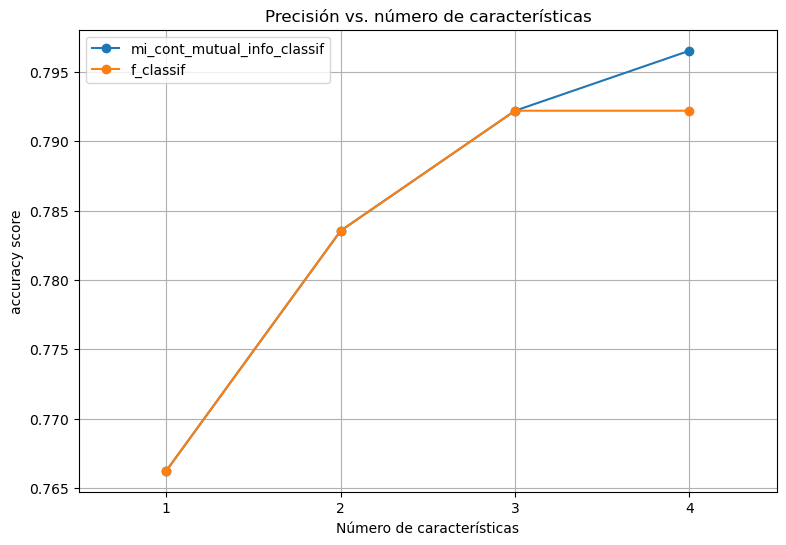

In [47]:
display(acc)
acc.plot(style='o-', grid=True, figsize=(9,6),
    xticks=range(len(acc) + 1),
    xlim = (0.5, len(acc) + 0.5),
    title='Precisión vs. número de características', 
    xlabel='Número de características',
    ylabel='accuracy score')
plt.show()

Aunque no podamos saber como se verá exactamente esta gráfica después de una serie de ejecuciones, pues existe cierta pseudo-aletoriedad en la función `mi_cont_mutual_info_classif()`, debido al valor de su parámetro *discrete_features*, es probable que obtengamos distintos valores de accuracy para los distintos modelos. Esto se debe a que las características seleccionadas son distintas y, por lo general, el estadístico f nos proporcionará mejores resultado, pues es directamente proporcional a la distancia media de cada clase. Además, es normal obtener estos valores para el accuracy.

## Caso propuesto 2: predictores numéricos, respuesta numérica

En este caso usaremos un dataset sintético, generado con la función `make_regression()` de scikit learn

### Generación del dataset sintético

In [48]:
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10,
                       noise=0.1, random_state=1)

### División el dataset en train y test

En este apartado, se ha dividido el dataset en train y test, con un 80% de los datos para entrenamiento y un 20% para test.

In [49]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (670, 100) (670,)
Test (330, 100) (330,)


### Codificación del dataset

Tras dividir el conjunto de datos en entrenamiento y prueba, es importante estandarizar sus valores numéricos para que todos los valores estén en la misma escala. Esto es importante a la hora de evitar descompensaciones en el entrenamiento de nuestros modelos, ya que tienden a funcionar mejor cuando los valores de entrada están en la misma escala. Para ello, usaremos la clase `Encoder` que hemos definido anteriormente.

In [50]:
enc = Encoder()
X_train_enc, X_test_enc = enc.encode(X_train, X_test, str_columns=[i for i in range(len(X_train[0]) -1)])

### Regresion (`f_regression()`)

La función  `f_regression()` nos devuelve el valor del estadístico F para cada una de las características, y el p-value asociado a cada uno de ellos. Esto lo hace mediante la función `r_regression()` que calcula el coeficiente de correlación Pearson y, con este, se calcula el p-value asociado a dicho estadístico F. En resumen, la función `f_regression()` es una herramienta útil para la selección de características y análisis de la importancia de las mismas en un modelo de regresión lineal. Con esto dicho, podemos comenzar a trabajar con el dataset.


Debido a la gran cantidad de características que contiene el dataset hemos decido para este y el siguiente apartado quedarnos solo con las 4 mejores características, ya que de esta forma podremos visualizar los datos de forma más sencilla. Para la selección de estas caracteristicas usaremos la función `select_features()`, usando como función para la selección de características `f_regression()`.

In [51]:
# feature selection (using the encoded datset to train our model)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, f_regression, k=4)

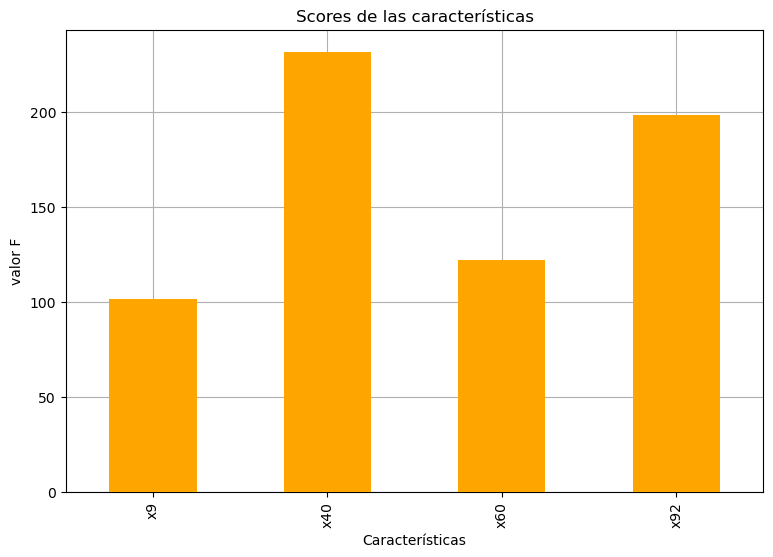

In [52]:
df = pd.DataFrame()
# Almacenamos los nombres de las características
df['features'] = [i for i in fs.get_feature_names_out()]
# Almacenamos los scores de las características
df['scores'] = [j for j in fs.scores_[fs.get_support()]]

# Mostramos el resultado
df['scores'].plot(kind='bar', xlabel = 'Características', ylabel = 'valor F', title = 'Scores de las características', figsize=(9,6), zorder = 3 , color = 'orange')
plt.xticks(range(len(fs.get_feature_names_out())), fs.get_feature_names_out())
plt.grid(zorder=0)
plt.show()

### Mutual information (caso regresión)

La función  `mutual_info_regression()` nos devuelve una medida de dependencia para cada una de las características con la variable resultado. Esto lo hace mediante una estimación de la entropía a partir de la distancia entre los k-vecinos más cercanos. En resumen, la función `mutual_info_regression()` es una herramienta útil para la selección de características y análisis de la importancia de las mismas en un modelo de regresión lineal. Con esto dicho, podemos comenzar a trabajar con el dataset.

Debido a la gran cantidad de características que contiene el dataset hemos decido también para este apartado quedarnos solo con las 4 mejores características, ya que de esta forma podremos visualizar los datos de forma más sencilla. Para la selección de estas caracteristicas usaremos la función `select_features()`, usando como función para la selección de características `mutual_info_regression()`.

In [53]:
X_train_mi, X_test_mi, mis = select_features(X_train, y_train, X_test, mutual_info_regression, k=4)

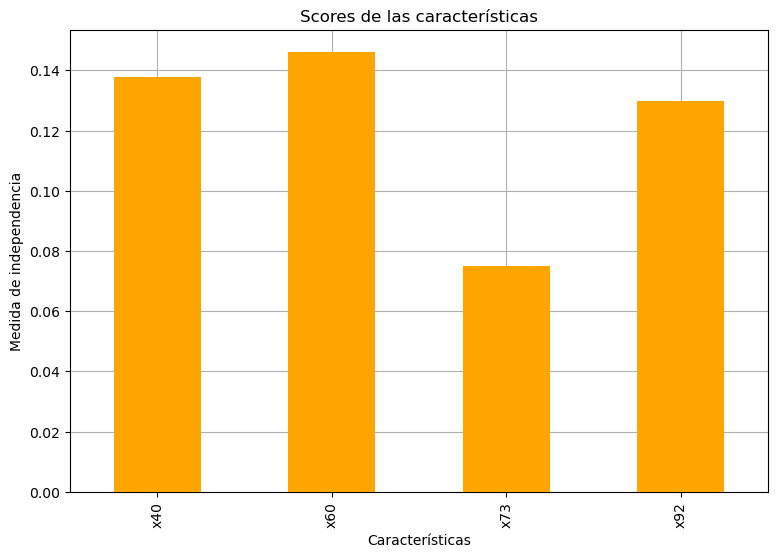

In [54]:
df = pd.DataFrame()
# Almacenamos los nombres de las características
df['features'] = [i for i in mis.get_feature_names_out()]
# Almacenamos los scores de las características
df['scores'] = [j for j in mis.scores_[mis.get_support()]]

# Mostramos el resultado
df['scores'].plot(kind='bar', xlabel = 'Características', ylabel = 'Medida de independencia', title = 'Scores de las características', figsize=(9,6), zorder=3, color = 'orange')
plt.xticks(range(len(mis.get_feature_names_out())), mis.get_feature_names_out())
plt.grid(zorder=0)
plt.show()

### Modelo con todas las características

Usar el modelo `LinearRegression()` y la métrica `mean_absolute_error`

Para este apartado se ha usado el modelo `LinearRegression()` de scikit learn, el cual es un modelo de regresión lineal. Para evaluar el modelo se ha usado la métrica `mean_absolute_error`, la cual es la media de los errores absolutos entre los valores reales y los valores predichos.

In [55]:
model = LinearRegression()
model.fit(X_train_enc, y_train)

yhat = model.predict(X_test_enc)
error_total = mean_absolute_error(y_test, yhat)
print(f'La media de los errores absolutos para el modelo con todas las características ha sido de: {error_total:.2f}')

La media de los errores absolutos para el modelo con todas las características ha sido de: 0.09


### Modelo con las 10 mejores características obtenidas con la regresión `f_regression()`

Para la selección de estas caracteristicas usaremos la función `select_features()`, usando como función para la selección de características `f_regression()` con un _k_ igual a 10.

In [56]:
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train, X_test_enc, f_regression, k=10)

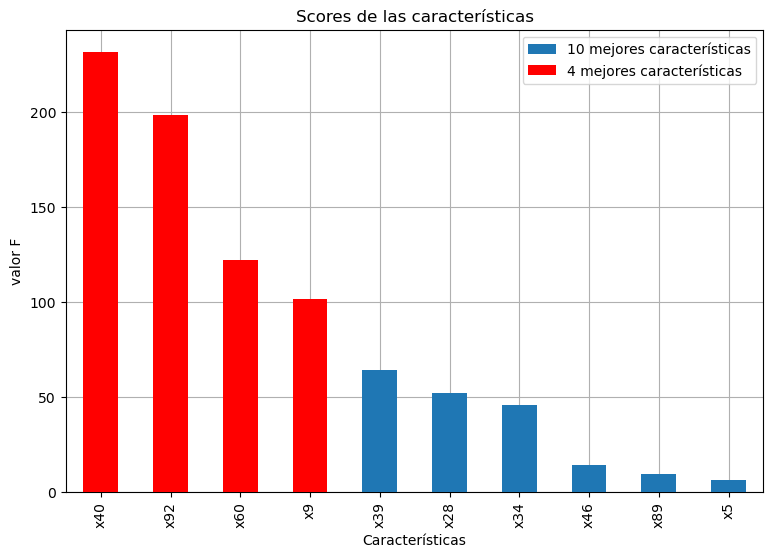

In [57]:
f_data = pd.DataFrame()
# Almacenamos los nombres de las características y sus scores ordenados de mayor a menor por su score
f_data['features'] = [i for i in fs.get_feature_names_out()]
f_data['scores'] = [j for j in fs.scores_[fs.get_support()]]
f_data = f_data.sort_values(by='scores', ascending=False, ignore_index=True)

# Mostramos el resultado
f_data['scores'].plot(kind='bar', xlabel = 'Características', ylabel = 'valor F', title = 'Scores de las características', figsize=(9,6), zorder=3, label='10 mejores características')
plt.bar(range(4), f_data['scores'][:4], color='red', zorder=3, width=0.5, label='4 mejores características')
plt.xticks(range(len(f_data['features'])), f_data['features'])
plt.grid(zorder=0)
plt.legend(loc='upper right')
plt.show()

Tras esto se ha usado el modelo `LinearRegression()` de scikit learn, el cual hemos entrenado con los datos obtenidos del apartado anterior. Para evaluar el modelo se ha usado la métrica `mean_absolute_error`.

In [58]:
modelf = LinearRegression()
modelf.fit(X_train_fs, y_train)

yhat = modelf.predict(X_test_fs)
error_f = mean_absolute_error(y_test, yhat)
print(f'La media de los errores absolutos para el modelo de f_regression con las 10 mejores características ha sido de: {error_f:.2f}')

La media de los errores absolutos para el modelo de f_regression con las 10 mejores características ha sido de: 2.74


### Modelo con las 10 mejores características obtenidas con *mutual information*

Para la selección de estas caracteristicas usaremos la función `select_features()`, usando como función para la selección de características `mutual_info_regression()` con un _k_ igual a 10.

In [59]:
X_train_mi, X_test_mi, mis = select_features(X_train, y_train, X_test, mutual_info_regression, k=10)

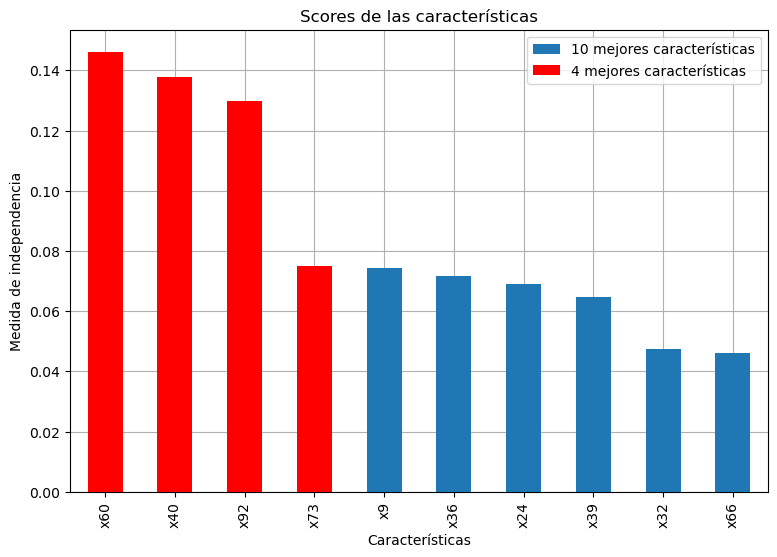

In [60]:
mis_data = pd.DataFrame()
# Almacenamos los nombres de las características y sus scores ordenados de mayor a menor por su score
mis_data['features'] = [i for i in mis.get_feature_names_out()]
mis_data['scores'] = [j for j in mis.scores_[mis.get_support()]]
mis_data = mis_data.sort_values(by='scores', ascending=False, ignore_index=True)


# Mostramos el resultado
mis_data['scores'].plot(kind='bar', xlabel = 'Características', ylabel = 'Medida de independencia', title = 'Scores de las características', figsize=(9,6), zorder=3, label='10 mejores características')
plt.bar(range(4), mis_data['scores'][:4], color='red', zorder=3, width=0.5, label='4 mejores características')
plt.xticks(range(len(mis_data['features'])), mis_data['features'])
plt.grid(zorder=0)
plt.legend(loc='upper right')
plt.show()

Tras esto se ha usado el modelo `LinearRegression()` de scikit learn, el cual hemos entrenado con los datos obtenidos del apartado anterior. Para evaluar el modelo se ha usado la métrica `mean_absolute_error`.

In [61]:
modelmi = LinearRegression()
modelmi.fit(X_train_mi, y_train)

yhat = modelmi.predict(X_test_mi)
error_mi = mean_absolute_error(y_test, yhat)
print(f'La media de los errores absolutos para el modelo de mutual_information_regression con las 10 mejores características ha sido de: {error_mi:.2f}')

La media de los errores absolutos para el modelo de mutual_information_regression con las 10 mejores características ha sido de: 68.21


### Comparativa de resultados y comentarios

In [62]:
mae = compare_models(X_train, X_test, y_test, funcs= [mutual_info_regression, f_regression], k = 10, precision_func= mean_absolute_error, m = LinearRegression())

,mutual_info_regression,f_regression
1,148.782122,136.641332
2,125.054197,116.514517
3,96.863183,96.863183
4,97.133275,77.831844
5,78.286641,68.227554
6,78.727341,55.249695
7,78.833757,32.906988
8,68.258883,16.392450
9,68.209634,2.731532
10,68.209581,2.739756


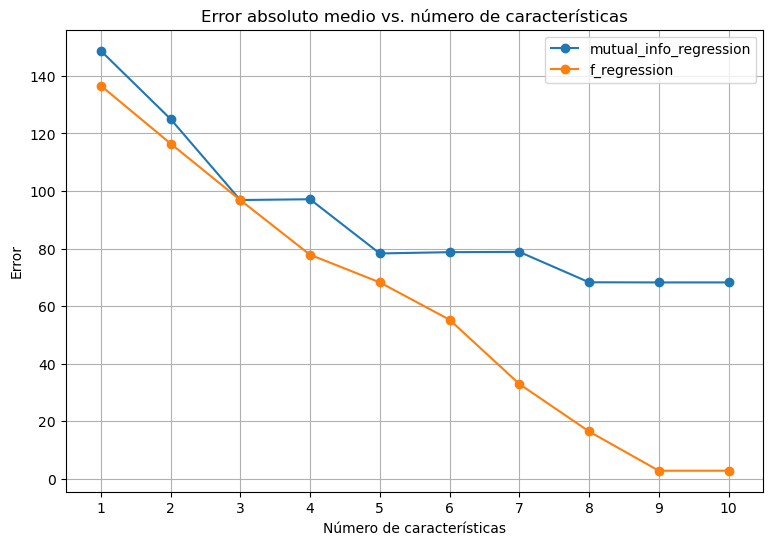

In [63]:
display(mae)
mae.plot(style='o-', grid=True, figsize=(9,6),
    xticks=range(len(mae) + 1),
    xlim = (0.5, len(mae) + 0.5),
    title='Error absoluto medio vs. número de características', 
    xlabel='Número de características',
    ylabel='Error')
plt.show()

Después de analizar los resultados obtenidos, se puede observar que el modelo que ha demostrado mejor rendimiento ha sido el entrenado con todas las características del dataset, dado que ha presentado un error medio absoluto de 0.09. Sin embargo, si tuviésemos que seleccionar uno de los modelos entrenados con las 10 mejores características, elegiríamos el entrenado con las características obtenidas mediante la función `f_regression()`, ya que presenta un error medio absoluto más bajo, en todos los casos excepto en _k_ = 3, donde se mantiene igual. Además, parece ser un modelo más robusto en comparación al modelo entrenado con los datos de la función `mutual_info_regression()`, ya que esta función no es determinista, lo que implica que en cada ejecución se obtendrá un resultado distinto. Asimismo, el modelo de la función `mutual_info_regression()` se basa en estimaciones de la entropía, lo que puede hacer que no sea completamente fiable. Por tanto, si tuviésemos que seleccionar un modelo, elegiríamos el entrenado con las características obtenidas mediante la función `f_regression()`, no solo por sus resultados superiores, sino también por los cálculos utilizados para determinar la importancia de las características.

In [64]:
f_features = pd.DataFrame(f_data['features'])
mis_features = pd.DataFrame(mis_data['features'])
features = pd.concat([f_features, mis_features], axis=1)
features.columns = ['f_regression', 'mutual_info_regression']
display(features)

,f_regression,mutual_info_regression
0,x40,x60
1,x92,x40
2,x60,x92
3,x9,x73
4,x39,x9
5,x28,x36
6,x34,x24
7,x46,x39
8,x89,x32
9,x5,x66


Por último, dejamos aquí una tabla donde se pueden observar las características ordenadas de mayor a menor importancia, según el modelo entrenado con todas las características del dataset. En el que podemos observar que las 5 primeras características son casi las mismas tanto para el modelo entrenado con la función `f_regression()` como para el modelo entrenado con la función `mutual_info_regression()`. Lo que explicaría porque los resultados de ambos modelos son tan similares, para _k_ < 6. Llegando a ser iguales en _k_ = 3 debido a que las 3 primeras características son las mismas para ambos modelos.

### NOTAS

1. Cuando se utiliza la función `SelectKBest()` junto con `f_regression()`, solo se obtiene el valor del estadístico F para cada característica, no se devuelve el valor p asociado.
2. Los valores devueltos por las funciones `f_regression()` y `mutual_info_regression()` son siempre positivos debido a la definición de estas medidas de importancia de características, las cuales tienen un rango de valores en el intervalo [0, ∞) en el caso de los estadísticos F y de [0,1] para los valores p en `f_regression()` y de [0,1] para las medidas de independencia en `mutual_info_regression()`. Por lo tanto, no es necesario aplicar una transformación de signo a los valores devueltos por estas funciones.
3. En el caso de la función `f_regression()`, el valor del estadístico F es cero cuando las variables son independientes, y el valor máximo es infinito cuando las variables son completamente dependientes.
4. En el caso de la función `mutual_info_regression()`, el valor de la medida de dependencia es cero cuando las variables son independientes, y el valor máximo es 1 cuando las variables son completamente dependientes.                                                                                                                                                           